# Time Series Modeling (ARIMA Methods) 

In [ ]:
import pandas as pd
import plotly.express as px
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import numpy as np

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



### Import the Amazon stock price data set (AMZN_data.csv) and plot a line chart with the observed daily closing prices.

In [ ]:
df = pd.read_csv('https://tf-assets-prod.s3.amazonaws.com/tf-curric/data-science/Data%20Sets%20Time%20Series%20Analysis/Time%20Series%20-%20Day%204/AMZN_data.csv')

In [ ]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1259 entries, 0 to 1258
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    1259 non-null   object 
 1   open    1259 non-null   float64
 2   high    1259 non-null   float64
 3   low     1259 non-null   float64
 4   close   1259 non-null   float64
 5   volume  1259 non-null   int64  
 6   Name    1259 non-null   object 
dtypes: float64(4), int64(1), object(2)
memory usage: 69.0+ KB


,date,open,high,low,close,volume,Name
0,2013-02-08,261.40,265.25,260.555,261.95,3879078,AMZN
1,2013-02-11,263.20,263.25,256.600,257.21,3403403,AMZN
2,2013-02-12,259.19,260.16,257.000,258.70,2938660,AMZN
3,2013-02-13,261.53,269.96,260.300,269.47,5292996,AMZN
4,2013-02-14,267.37,270.65,265.400,269.24,3462780,AMZN


In [ ]:
df['date'] = pd.to_datetime(df['date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1259 entries, 0 to 1258
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    1259 non-null   datetime64[ns]
 1   open    1259 non-null   float64       
 2   high    1259 non-null   float64       
 3   low     1259 non-null   float64       
 4   close   1259 non-null   float64       
 5   volume  1259 non-null   int64         
 6   Name    1259 non-null   object        
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 69.0+ KB


### Run an Autoregression (AR) model on the series and add the results to a column in the dataframe.

In [ ]:
# AR
model = AR(df['close']).fit()
df['AR'] = model.predict()

In [ ]:
model.k_ar

23

### Plot a multi-line chart comparing the AR model's results with the observed values.

In [ ]:
def ilinechart(df, x, y, groups=None, title=''):
  fig = px.line(df, x=x, y=y, color=groups, title=title, 
                template='none').update(layout=dict(title=dict(x=0.5)))

  fig.show()

In [ ]:
melted = pd.melt(df, id_vars='date', value_vars=['close', 'AR'], 
                 var_name='variable', value_name='value')

ilinechart(melted, 'date', 'value', groups='variable', title='Close vs. AR Model')

### Run a Moving Average (MA) model on the series and add the results to a column in the dataframe.

In [ ]:
# Moving Average
model = ARMA(df['close'], order=(0,1)).fit()
df['MA'] = model.predict()

### Print the model summary and add the model's results to the line chart with observations and the AR model results.

In [ ]:
print(model.summary())

                              ARMA Model Results                              
Dep. Variable:                  close   No. Observations:                 1259
Model:                     ARMA(0, 1)   Log Likelihood               -8047.769
Method:                       css-mle   S.D. of innovations            144.300
Date:                Fri, 24 Dec 2021   AIC                          16101.538
Time:                        00:18:28   BIC                          16116.952
Sample:                             0   HQIC                         16107.331
                                                                              
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const         576.9791      8.063     71.560      0.000     561.176     592.782
ma.L1.close     0.9834      0.004    226.363      0.000       0.975       0.992
                                    Roots       

In [ ]:
melted = pd.melt(df, id_vars='date', value_vars=['close', 'AR', 'MA'], 
                 var_name='variable', value_name='value')

ilinechart(melted, 'date', 'value', groups='variable', title='Close vs. Modeled')

### Run an Autoregressive Moving Average (ARMA) model on the series and add the results to a column in the dataframe.

Hint: You will need to make the time series stationary in order to run the ARMA model on it. The most common way to do this is by differncing, or subtracting the previous observed value from the current one.

In [ ]:
import statsmodels.api as sm

adf_test = sm.tsa.stattools.adfuller(df['close'])
results = pd.Series(adf_test[0:4], 
                    index=['ADF Test Statistic',
                            'P-Value', 
                            '# Lags Used',
                            '# Observations Used'])
for key, value in adf_test[4].items():
  results[f'Critical Value {key}'] = value

print(results)

ADF Test Statistic        2.483785
P-Value                   0.999044
# Lags Used               3.000000
# Observations Used    1255.000000
Critical Value 1%        -3.435571
Critical Value 5%        -2.863846
Critical Value 10%       -2.567998
dtype: float64


The closing prices are not stationary. We need to make them so in order to use ARMA.

In [ ]:
df['shift'] = df['close'].shift(1).fillna(method='bfill')
df['diff'] = df['close'] - df['shift']

In [ ]:
df.head()

,date,open,high,low,close,volume,Name,AR,MA,shift,diff
0,2013-02-08,261.40,265.25,260.555,261.95,3879078,AMZN,NaN,576.979115,261.95,0.00
1,2013-02-11,263.20,263.25,256.600,257.21,3403403,AMZN,NaN,419.486705,261.95,-4.74
2,2013-02-12,259.19,260.16,257.000,258.70,2938660,AMZN,NaN,468.819994,257.21,1.49
3,2013-02-13,261.53,269.96,260.300,269.47,5292996,AMZN,NaN,419.440807,258.70,10.77
4,2013-02-14,267.37,270.65,265.400,269.24,3462780,AMZN,NaN,457.053053,269.47,-0.23


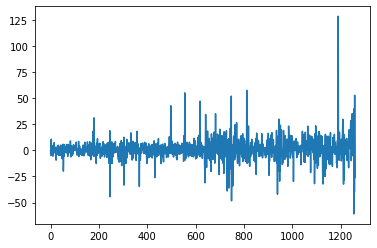

In [ ]:
df['diff'].plot()

In [ ]:
adf_test = sm.tsa.stattools.adfuller(df['diff'])
results = pd.Series(adf_test[0:4], 
                    index=['ADF Test Statistic',
                            'P-Value', 
                            '# Lags Used',
                            '# Observations Used'])
for key, value in adf_test[4].items():
  results[f'Critical Value {key}'] = value

print(results)

ADF Test Statistic      -21.376625
P-Value                   0.000000
# Lags Used               2.000000
# Observations Used    1256.000000
Critical Value 1%        -3.435567
Critical Value 5%        -2.863844
Critical Value 10%       -2.567997
dtype: float64


Now that we have made our closing prices stationary we can plug them into the ARMA model. 

In [ ]:
# ARMA
model = ARMA(df['diff'], order=(2,1)).fit()
df['ARMA'] = model.predict() + df['close']

### Print the model summary and generate a multi-line chart that compares the ARMA model's results with those from the AR and MA models.

Hint: You will need to de-difference the model results by adding the previous observed values to them.

In [ ]:
print(model.summary())

                              ARMA Model Results                              
Dep. Variable:                   diff   No. Observations:                 1259
Model:                     ARMA(2, 1)   Log Likelihood               -4736.784
Method:                       css-mle   S.D. of innovations             10.417
Date:                Fri, 24 Dec 2021   AIC                           9483.569
Time:                        00:18:46   BIC                           9509.259
Sample:                             0   HQIC                          9493.223
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9186      0.300      3.064      0.002       0.331       1.506
ar.L1.diff    -0.4441      0.310     -1.432      0.153      -1.052       0.164
ar.L2.diff     0.0380      0.030      1.262      0.2

In [ ]:
melted = pd.melt(df, id_vars='date', value_vars=['close', 'AR', 'MA', 'ARMA'], 
                 var_name='variable', value_name='value')

ilinechart(melted, 'date', 'value', groups='variable', title='Close vs. Modeled')

### Run an Autoregressive Integrated Moving Average (ARIMA) model on the series and add the results to a column in the dataframe.

In [ ]:
model = ARIMA(df['close'], order=(1,2,1)).fit()
df['ARIMA'] = model.predict(typ='levels')

### Print the model summary and generate a multi-line chart that compares the 

---

ARIMA model's results to the observed values.

In [ ]:
print(model.summary())

                             ARIMA Model Results                              
Dep. Variable:               D2.close   No. Observations:                 1257
Model:                 ARIMA(1, 2, 1)   Log Likelihood               -4732.014
Method:                       css-mle   S.D. of innovations             10.410
Date:                Fri, 24 Dec 2021   AIC                           9472.028
Time:                        00:18:53   BIC                           9492.574
Sample:                             2   HQIC                          9479.750
                                                                              
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0020      0.001      2.502      0.012       0.000       0.004
ar.L1.D2.close    -0.0128      0.028     -0.453      0.650      -0.068       0.043
ma.L1.D2.close    -1.0000      0.003

In [ ]:
melted = pd.melt(df, id_vars='date', value_vars=['close', 'AR', 'MA', 'ARMA', 'ARIMA'], 
                 var_name='variable', value_name='value')

ilinechart(melted, 'date', 'value', groups='variable', title='Close vs. Modeled')

### Run an Seasonal Autoregressive Integrated Moving Average (SARIMA) model on the series and add the results to a column in the dataframe.

In [ ]:
model = SARIMAX(df['close'], order=(1, 1, 1), seasonal_order=(1,1,1,1)).fit()
df['SARIMA'] = model.predict()

### Print the model summary and generate a multi-line chart that compares the SARMA model's results with the observed values.

In [ ]:
print(model.summary())

                                 Statespace Model Results                                
Dep. Variable:                             close   No. Observations:                 1259
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 1)   Log Likelihood               -4755.986
Date:                           Fri, 24 Dec 2021   AIC                           9521.972
Time:                                   00:18:58   BIC                           9547.654
Sample:                                        0   HQIC                          9531.624
                                          - 1259                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3860      0.013     29.896      0.000       0.361       0.411
ma.L1         -0.8560      0.008   -104.273

In [ ]:
melted = pd.melt(df, id_vars='date', value_vars=['close', 'SARIMA'], 
                 var_name='variable', value_name='value')

ilinechart(melted, 'date', 'value', groups='variable', title='Close vs. Modeled')

### Run an Seasonal Autoregressive Integrated Moving Average with Exogenous Factors (SARIMAX) model on the series and add the results to a column in the dataframe.

Use the daily Open prices as the exogenous factors.

In [ ]:
model = SARIMAX(df['close'], exog=df['open'], order=(1, 1, 1), seasonal_order=(0,0,0,0)).fit()
df['SARIMAX'] = model.predict()

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



### Print the model summary and generate a multi-line chart that compares the SARMAX model's results with the SARIMA model's values.

In [ ]:
print(model.summary())

                           Statespace Model Results                           
Dep. Variable:                  close   No. Observations:                 1259
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -4452.470
Date:                Fri, 24 Dec 2021   AIC                           8912.941
Time:                        01:10:43   BIC                           8933.490
Sample:                             0   HQIC                          8920.663
                               - 1259                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
open           0.9996      0.001   1610.638      0.000       0.998       1.001
ar.L1          0.0074      0.015      0.500      0.617      -0.021       0.036
ma.L1         -1.0000      0.344     -2.903      0.0

In [ ]:
melted = pd.melt(df, id_vars='date', value_vars=['close', 'SARIMA', 'SARIMAX'], 
                 var_name='variable', value_name='value')

ilinechart(melted, 'date', 'value', groups='variable', title='Close vs. Modeled')

### Evaluate the performance of all the models and compare to each other, using Mean Absolute Error and Root Mean Squared Error as your evaluation metrics.

In [ ]:
models = ['AR', 'MA', 'ARMA', 'ARIMA', 'SARIMA', 'SARIMAX']

for model in models:
    diff = df['close'] - df[model]
    mae = diff.abs().mean()
    rmse = np.sqrt(np.mean(diff**2))
    print(f'Model {model} - MAE: {mae} | RMSE: {rmse}')

Model AR - MAE: 6.63675478194837 | RMSE: 10.399040851606218
Model MA - MAE: 124.57766603584766 | RMSE: 144.6307251244663
Model ARMA - MAE: 0.9447453841247849 | RMSE: 1.0341515386384323
Model ARIMA - MAE: 6.584141372287244 | RMSE: 10.423007961800689
Model SARIMA - MAE: 7.0296884245958475 | RMSE: 13.490797145386495
Model SARIMAX - MAE: 5.553636035101273 | RMSE: 8.31711639308446


The ARMA model appears to be the best model for this dataset. It has the lower RSME and MAE residual scores. 